In [54]:
import os
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import random
import csv
import ast

In [55]:

def file_exists(filepath):
    return os.path.isfile(filepath)

def is_numeric_value(val):
    try:
        float(val)
        return True
    except ValueError:
        return False

def populate_data_time(sampled_powermodes, path, filename, offset_dict, model):
    cpu_cores_multipler = 1
    cpu_frq_divider = 1
    gpu_frq_divider = 1
    mem_frq_divider = 1

    all_data = []

    for powermode in sampled_powermodes:
        # Get the offset before scaling
        offset = offset_dict.get(powermode, -1)
        file = path + "/" + "pm_" + powermode + "/" + filename
        cores = int(powermode.split("_")[0]) * cpu_cores_multipler
        cpu = int(powermode.split("_")[1]) / cpu_frq_divider
        gpu = int(powermode.split("_")[2]) / gpu_frq_divider
        mem = int(powermode.split("_")[3]) / mem_frq_divider

        temp_df = pd.read_csv(file, header=None)
        # temp_df = temp_df[temp_df[4].replace('.', '', 1).astype(str).str.isnumeric()]
        # temp_df = temp_df[temp_df[4].apply(is_numeric_value)]
        # print(temp_df.head())

        if offset == -1:
            start = len(temp_df) - 40
            end = len(temp_df)
        elif offset == 0:
            start = offset + 1
            end = start + 40
        else:
            start = offset
            end = start + 40

        diff = end-start
        if len(temp_df[start:end]) != 40:
            print("Diff :", diff)
            print("Start :",start)
            print("End:",end)
            print("Offset: ",offset)
            print("Powermode :",powermode)
            print("Length :",len(temp_df))

        temp_df = temp_df.iloc[start:end]
        if model == 'yolo':
            temp_df = temp_df.iloc[:,2].astype(float)

        else:
            temp_df = temp_df.iloc[:,4].astype(float)

        temp_df = temp_df.to_frame() 
        # print(temp_df.head())
        temp_df['Cores'] = cores
        temp_df['CPU_frequency'] = cpu
        temp_df['GPU_frequency'] = gpu
        temp_df['Memory_frequency'] = mem
        temp_df.columns = ['Minibatch_time', 'Cores', 'CPU_frequency', 'GPU_frequency', 'Memory_frequency']
        # print(temp_df.head())

        all_data.append(temp_df)

    master_df = pd.concat(all_data, ignore_index=True)
    return master_df


In [56]:
def populate_data_power(all_powermodes, path, filename, tg_filename, offset_dict, start_dict, end_dict):

    rows = []
    for powermode in all_powermodes:
        offset = offset_dict.get(powermode, -1)
        start_time = start_dict.get(powermode, -1)
        end_time = end_dict.get(powermode, -1)
        file = path + "/" + "pm_" + powermode + "/" + filename
        tg_file = path + "/" + "pm_" + powermode + "/" + tg_filename

        tg_df = pd.read_csv(tg_file)
        filtered_df = tg_df[(tg_df['log_time'] >= start_time) & (tg_df['log_time'] <= end_time)]
        power_list = filtered_df['power cur'].astype(float).dropna().tolist()

        required_length = 12
        if len(power_list) < required_length:
            repeats_required = -(-required_length // len(power_list))  
            power_list = (power_list * repeats_required)[:required_length]
            
        power_list = power_list[:12]  # If more than 12, truncate to the first 12 samples


        # Split the powermode into its components
        cores, cpu, gpu, mem = powermode.split("_")

        for sample in power_list:
            rows.append({
                'cores': cores,
                'cpu': cpu,
                'gpu': gpu,
                'mem': mem,
                'power_sample': sample
            })

    minibatch_power_df = pd.DataFrame(rows)
    # minibatch_power_df.to_csv("val_power_400.csv", index=False)
    return minibatch_power_df

In [57]:
def generate_powermodes():
    cpu_core_vals=[4, 8, 12] #3 possible values
    gpu_frequencies=[1300500000, 1134750000, 930750000, 726750000, 522750000, 318750000, 114750000] #in Hz, 7 possible values
    cpu_frequencies=[422400, 729600, 1036800, 1344000, 1651200, 1958400, 2201600] #in kHz, 7 possible values
    mem_frequencies=[2133000000, 3199000000, 665600000] #in Hz, 3 possible values
    #get combinations of all 4 as powermode Ex.2_1300500000_268800_204000000
    all_powermodes=[] 
    for cpu_core in cpu_core_vals:
        for cpu_frequency in cpu_frequencies:
            for gpu_frequency in gpu_frequencies:
                for mem_frequency in mem_frequencies:
                    all_powermodes.append(str(cpu_core)+"_"+str(cpu_frequency)+"_"+str(gpu_frequency)+"_"+str(mem_frequency))
    return all_powermodes

In [58]:
def extract_offsets_from_csv(csv_file):
    df = pd.read_csv(csv_file) 
    powermode_offsets = {}
    start_times = {}
    end_times = {}
    # Iterate through the DataFrame and populate the dictionary
    for _, row in df.iterrows():
        powermode = f"{int(row['cores'])}_{int(row['cpu'])}_{int(row['gpu'])}_{int(row['mem'])}"
        offset = int(row['skip_index'])
        start_time = float(row['start_time'])
        end_time = float(row['end_time'])
        powermode_offsets[powermode] = offset
        start_times[powermode] = start_time
        end_times[powermode] = end_time
    return powermode_offsets, start_times, end_times

In [59]:
df = pd.read_csv("/home/saisamarth/exp/mobnet_train_data_final.csv")
df

,cores,cpu,gpu,mem,observed_time,observed_power
0,2,268800,1300500000,204000000,1105.067078,17.7045
1,2,268800,1300500000,2133000000,649.863098,18.7580
2,2,268800,1300500000,3199000000,615.035431,19.7600
3,2,268800,1300500000,665600000,751.245148,18.2540
4,2,268800,1236750000,204000000,3289.224731,14.4450
...,...,...,...,...,...,...
4363,12,2201600,216750000,665600000,455.977402,18.2570
4364,12,2201600,114750000,204000000,1117.970886,15.9490
4365,12,2201600,114750000,2133000000,775.267059,17.3570
4366,12,2201600,114750000,3199000000,772.271240,18.1630


In [60]:
df['powermode'] = df[['cores', 'cpu', 'gpu', 'mem']].apply(lambda row: '_'.join(map(str, row)), axis=1)
df

,cores,cpu,gpu,mem,observed_time,observed_power,powermode
0,2,268800,1300500000,204000000,1105.067078,17.7045,2_268800_1300500000_204000000
1,2,268800,1300500000,2133000000,649.863098,18.7580,2_268800_1300500000_2133000000
2,2,268800,1300500000,3199000000,615.035431,19.7600,2_268800_1300500000_3199000000
3,2,268800,1300500000,665600000,751.245148,18.2540,2_268800_1300500000_665600000
4,2,268800,1236750000,204000000,3289.224731,14.4450,2_268800_1236750000_204000000
...,...,...,...,...,...,...,...
4363,12,2201600,216750000,665600000,455.977402,18.2570,12_2201600_216750000_665600000
4364,12,2201600,114750000,204000000,1117.970886,15.9490,12_2201600_114750000_204000000
4365,12,2201600,114750000,2133000000,775.267059,17.3570,12_2201600_114750000_2133000000
4366,12,2201600,114750000,3199000000,772.271240,18.1630,12_2201600_114750000_3199000000


In [61]:
df_441 = generate_powermodes()

df_441 = pd.DataFrame(df_441, columns=['powermode'])
df_441

,powermode
0,4_422400_1300500000_2133000000
1,4_422400_1300500000_3199000000
2,4_422400_1300500000_665600000
3,4_422400_1134750000_2133000000
4,4_422400_1134750000_3199000000
...,...
436,12_2201600_318750000_3199000000
437,12_2201600_318750000_665600000
438,12_2201600_114750000_2133000000
439,12_2201600_114750000_3199000000


In [62]:
df1 = df[df['powermode'].isin(list(df_441['powermode'].values))]
df1

,cores,cpu,gpu,mem,observed_time,observed_power,powermode
781,4,422400,1300500000,2133000000,383.251877,20.964,4_422400_1300500000_2133000000
782,4,422400,1300500000,3199000000,401.069717,21.571,4_422400_1300500000_3199000000
783,4,422400,1300500000,665600000,440.721237,20.671,4_422400_1300500000_665600000
789,4,422400,1134750000,2133000000,414.636948,19.260,4_422400_1134750000_2133000000
790,4,422400,1134750000,3199000000,395.498352,20.313,4_422400_1134750000_3199000000
...,...,...,...,...,...,...,...
4358,12,2201600,318750000,3199000000,287.276321,22.587,12_2201600_318750000_3199000000
4359,12,2201600,318750000,665600000,373.794312,19.465,12_2201600_318750000_665600000
4365,12,2201600,114750000,2133000000,775.267059,17.357,12_2201600_114750000_2133000000
4366,12,2201600,114750000,3199000000,772.271240,18.163,12_2201600_114750000_3199000000


In [63]:
merged_df = pd.merge(df_441, df, on='powermode', how='left')
merged_df

,powermode,cores,cpu,gpu,mem,observed_time,observed_power
0,4_422400_1300500000_2133000000,4,422400,1300500000,2133000000,383.251877,20.964
1,4_422400_1300500000_3199000000,4,422400,1300500000,3199000000,401.069717,21.571
2,4_422400_1300500000_665600000,4,422400,1300500000,665600000,440.721237,20.671
3,4_422400_1134750000_2133000000,4,422400,1134750000,2133000000,414.636948,19.260
4,4_422400_1134750000_3199000000,4,422400,1134750000,3199000000,395.498352,20.313
...,...,...,...,...,...,...,...
436,12_2201600_318750000_3199000000,12,2201600,318750000,3199000000,287.276321,22.587
437,12_2201600_318750000_665600000,12,2201600,318750000,665600000,373.794312,19.465
438,12_2201600_114750000_2133000000,12,2201600,114750000,2133000000,775.267059,17.357
439,12_2201600_114750000_3199000000,12,2201600,114750000,3199000000,772.271240,18.163


In [64]:
merged_df.drop(columns=['powermode'], inplace=True)
merged_df

,cores,cpu,gpu,mem,observed_time,observed_power
0,4,422400,1300500000,2133000000,383.251877,20.964
1,4,422400,1300500000,3199000000,401.069717,21.571
2,4,422400,1300500000,665600000,440.721237,20.671
3,4,422400,1134750000,2133000000,414.636948,19.260
4,4,422400,1134750000,3199000000,395.498352,20.313
...,...,...,...,...,...,...
436,12,2201600,318750000,3199000000,287.276321,22.587
437,12,2201600,318750000,665600000,373.794312,19.465
438,12,2201600,114750000,2133000000,775.267059,17.357
439,12,2201600,114750000,3199000000,772.271240,18.163


In [65]:
max(merged_df['observed_power'])


43.839

In [66]:
merged_df.loc[merged_df['observed_power'] >= 40, 'observed_time'] = 0
merged_df

,cores,cpu,gpu,mem,observed_time,observed_power
0,4,422400,1300500000,2133000000,383.251877,20.964
1,4,422400,1300500000,3199000000,401.069717,21.571
2,4,422400,1300500000,665600000,440.721237,20.671
3,4,422400,1134750000,2133000000,414.636948,19.260
4,4,422400,1134750000,3199000000,395.498352,20.313
...,...,...,...,...,...,...
436,12,2201600,318750000,3199000000,287.276321,22.587
437,12,2201600,318750000,665600000,373.794312,19.465
438,12,2201600,114750000,2133000000,775.267059,17.357
439,12,2201600,114750000,3199000000,772.271240,18.163


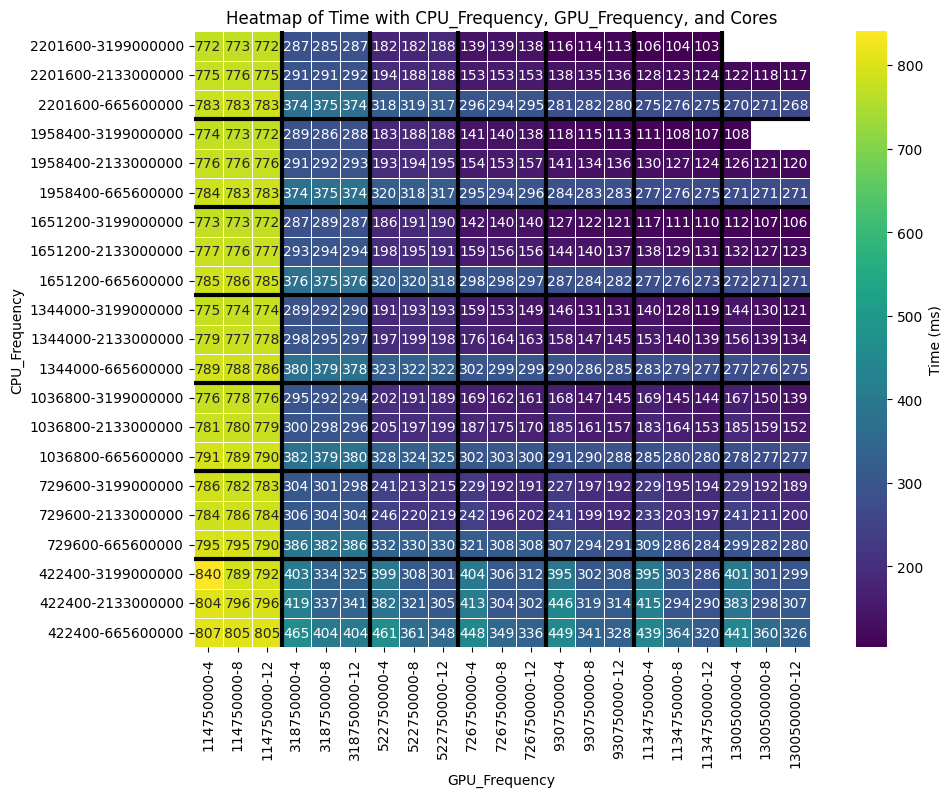

In [67]:
import numpy as np

# Pivot the DataFrame to prepare for plotting
pivot_df = merged_df.pivot_table(index=['cpu','mem'], columns=['gpu','cores'], values='observed_time', aggfunc='mean')
pivot_df.replace(0, np.nan, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Time (ms)'}, square=True)

for i in range(3, len(pivot_df.columns), 3):
    plt.axvline(x=i, color='black', linewidth=3)

for i in range(3, len(pivot_df.index), 3):
    plt.axhline(y=i, color='black', linewidth=3)

plt.title('Heatmap of Time with CPU_Frequency, GPU_Frequency, and Cores')
plt.xlabel('GPU_Frequency')
plt.ylabel('CPU_Frequency')

plt.gca().invert_yaxis()

plt.show()


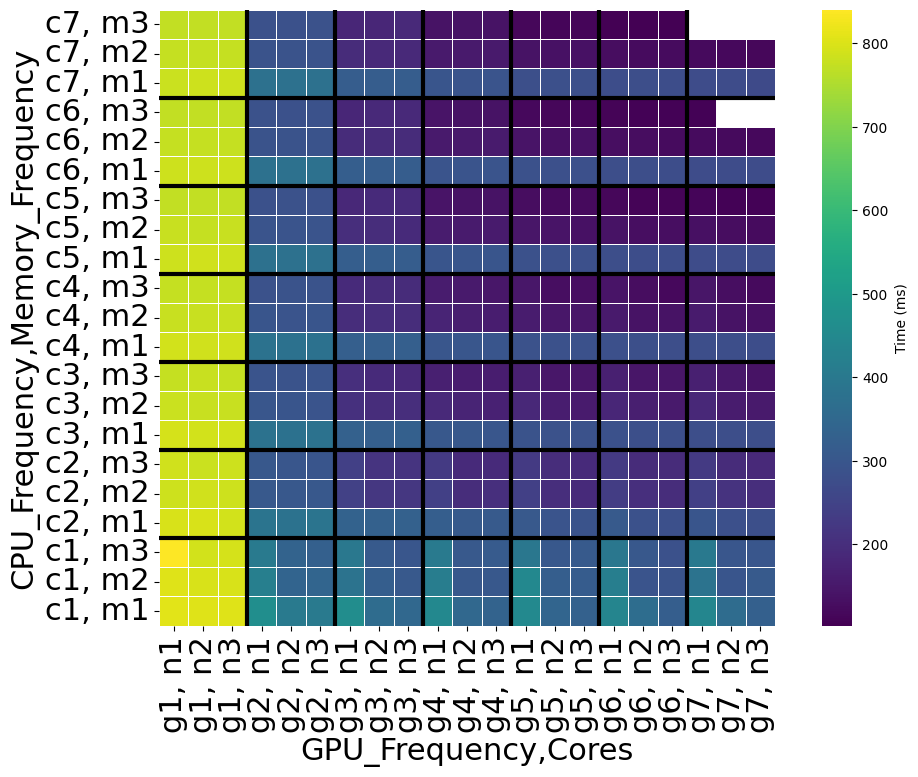

In [68]:
import numpy as np

# Pivot the DataFrame to prepare for plotting
pivot_df = merged_df.pivot_table(index=['cpu','mem'], columns=['gpu','cores'], values='observed_time', aggfunc='mean')
pivot_df.replace(0, np.nan, inplace=True)

# Create mappings for CPU and memory frequencies
cpu_mapping = {value: f'c{i+1}' for i, value in enumerate(sorted(merged_df['cpu'].unique()))}
mem_mapping = {value: f'm{i+1}' for i, value in enumerate(sorted(merged_df['mem'].unique()))}

gpu_mapping = {value: f'g{i+1}' for i, value in enumerate(sorted(merged_df['gpu'].unique()))}
cores_mapping = {value: f'n{i+1}' for i, value in enumerate(sorted(merged_df['cores'].unique()))}

# pivot_df.index = [(cpu_mapping[cpu], mem_mapping[mem]) for cpu, mem in pivot_df.index]
# pivot_df.columns = [(gpu_mapping[gpu], cores_mapping[cores]) for gpu, cores in pivot_df.columns]

pivot_df.index = [f'{cpu_mapping[cpu]}, {mem_mapping[mem]}' for cpu, mem in pivot_df.index]
pivot_df.columns = [f'{gpu_mapping[gpu]}, {cores_mapping[cores]}' for gpu, cores in pivot_df.columns]
# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='viridis', annot=False, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Time (ms)'}, square=True)

for i in range(3, len(pivot_df.columns), 3):
    plt.axvline(x=i, color='black', linewidth=3)

for i in range(3, len(pivot_df.index), 3):
    plt.axhline(y=i, color='black', linewidth=3)

# plt.title('Heatmap of Time with CPU_Frequency, GPU_Frequency, and Cores')
plt.xlabel('GPU_Frequency,Cores', fontsize=22)
plt.ylabel('CPU_Frequency,Memory_Frequency', fontsize=22)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


plt.gca().invert_yaxis()
plt.savefig('Binary_Search_Example.pdf', format='pdf',dpi=300, bbox_inches='tight')

plt.show()

{114750000: 'g1',
 318750000: 'g2',
 522750000: 'g3',
 726750000: 'g4',
 930750000: 'g5',
 1134750000: 'g6',
 1300500000: 'g7'}

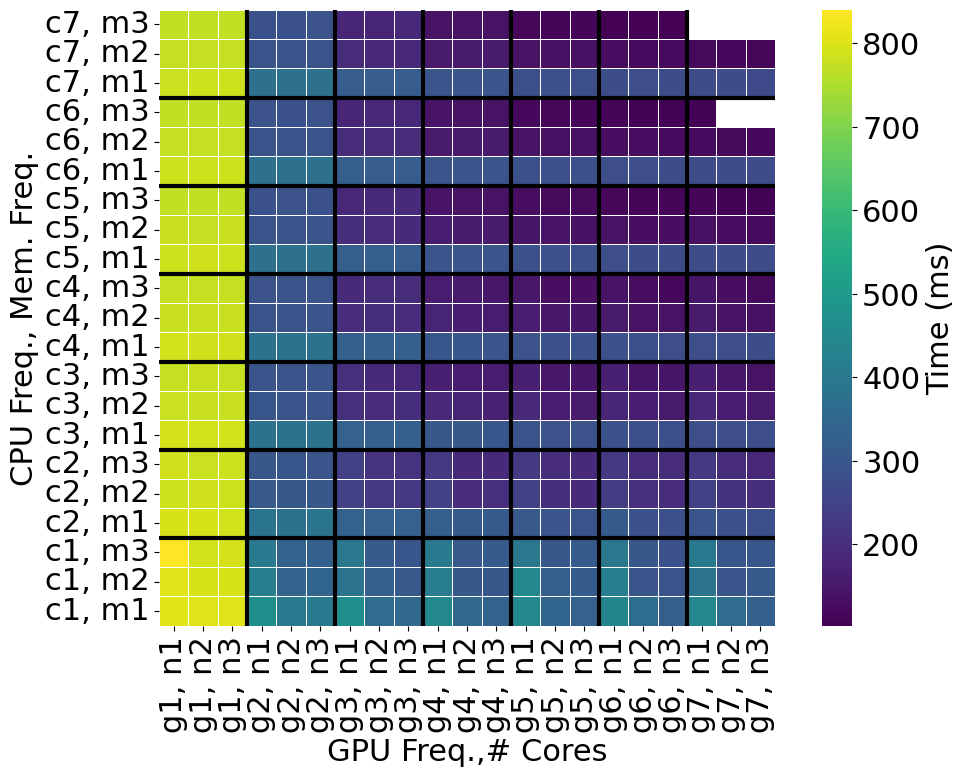

In [73]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df is already defined and contains the required data
# Pivot the DataFrame to prepare for plotting
pivot_df = merged_df.pivot_table(index=['cpu', 'mem'], columns=['gpu', 'cores'], values='observed_time', aggfunc='mean')
pivot_df.replace(0, np.nan, inplace=True)

# Create mappings for CPU and memory frequencies
cpu_mapping = {value: f'c{i+1}' for i, value in enumerate(sorted(merged_df['cpu'].unique()))}
mem_mapping = {value: f'm{i+1}' for i, value in enumerate(sorted(merged_df['mem'].unique()))}

gpu_mapping = {value: f'g{i+1}' for i, value in enumerate(sorted(merged_df['gpu'].unique()))}
cores_mapping = {value: f'n{i+1}' for i, value in enumerate(sorted(merged_df['cores'].unique()))}

# Adjust index and columns for the pivot_df
pivot_df.index = [f'{cpu_mapping[cpu]}, {mem_mapping[mem]}' for cpu, mem in pivot_df.index]
pivot_df.columns = [f'{gpu_mapping[gpu]}, {cores_mapping[cores]}' for gpu, cores in pivot_df.columns]

# Plotting the heatmap
plt.figure(figsize=(12, 8))
ax= sns.heatmap(
    pivot_df, 
    cmap='viridis', 
    annot=False, 
    fmt=".0f", 
    linewidths=.5, 
    cbar_kws={'label': 'Time (ms)'},  # Set font size for colorbar label
    square=True
)

# Add thicker lines for grouping
for i in range(3, len(pivot_df.columns), 3):
    plt.axvline(x=i, color='black', linewidth=3)

for i in range(3, len(pivot_df.index), 3):
    plt.axhline(y=i, color='black', linewidth=3)

# Set title and labels with increased font size
# plt.title('Heatmap of Time with CPU_Frequency, GPU_Frequency, and Cores', fontsize=22)
plt.xlabel('GPU Freq.,# Cores', fontsize=22)
plt.ylabel('CPU Freq., Mem. Freq.', fontsize=22)

# Increase the font size of tick labels
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
cbar.set_label('Time (ms)', size=22)
# Invert the y-axis
plt.gca().invert_yaxis()

# Show the plot
# plt.show()
gpu_mapping

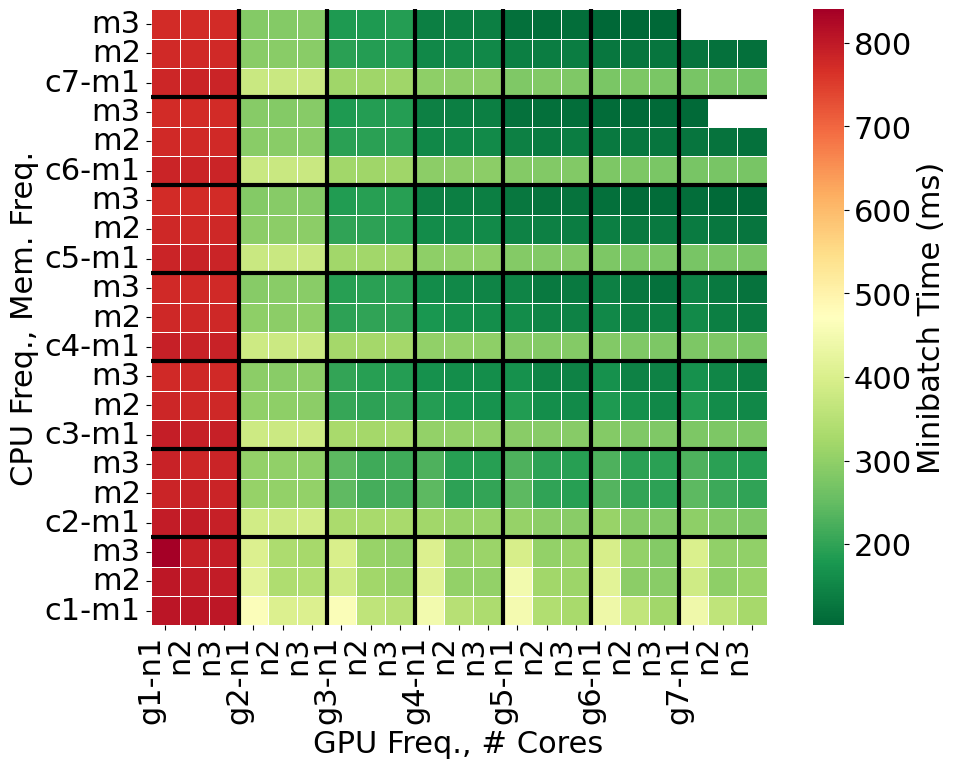

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df is already defined and contains the required data
# Pivot the DataFrame to prepare for plotting
pivot_df = merged_df.pivot_table(index=['cpu', 'mem'], columns=['gpu', 'cores'], values='observed_time', aggfunc='mean')
pivot_df.replace(0, np.nan, inplace=True)

# Create mappings for CPU and memory frequencies
cpu_mapping = {value: f'c{i+1}' for i, value in enumerate(sorted(merged_df['cpu'].unique()))}
mem_mapping = {value: f'm{i+1}' for i, value in enumerate(sorted(merged_df['mem'].unique()))}
gpu_mapping = {value: f'g{i+1}' for i, value in enumerate(sorted(merged_df['gpu'].unique()))}
cores_mapping = {value: f'n{i+1}' for i, value in enumerate(sorted(merged_df['cores'].unique()))}

# Adjust index and columns for the pivot_df with unique identifiers
pivot_df.index = [f'{cpu_mapping[cpu]}-{mem_mapping[mem]}' for cpu, mem in pivot_df.index]
pivot_df.columns = [f'{gpu_mapping[gpu]}-{cores_mapping[cores]}' for gpu, cores in pivot_df.columns]

# Plotting the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    pivot_df, 
    cmap='RdYlGn_r', 
    annot=False, 
    fmt=".0f", 
    linewidths=.5, 
    cbar_kws={'label': 'Time (ms)'},  # Set font size for colorbar label
    square=True
)

# Add thicker lines for grouping
for i in range(3, len(pivot_df.columns), 3):
    plt.axvline(x=i, color='black', linewidth=3)

for i in range(3, len(pivot_df.index), 3):
    plt.axhline(y=i, color='black', linewidth=3)

# Set title and labels with increased font size
plt.xlabel('GPU Freq., # Cores', fontsize=22)
plt.ylabel('CPU Freq., Mem. Freq.', fontsize=22)

# Increase the font size of tick labels
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Adjust tick labels to show unique labels only once
# x_labels = [label if i % 3 == 0 else '' for i, label in enumerate(pivot_df.columns)]
# y_labels = [label if i % 3 == 0 else '' for i, label in enumerate(pivot_df.index)]

x_labels = [label if i % 3 == 0 else ('n2' if i % 3 == 1 else 'n3') for i,label in enumerate(pivot_df.columns)]
y_labels = [label if i % 3 == 0 else ('m2' if i % 3 == 1 else 'm3') for i,label in enumerate(pivot_df.index)]

ax.set_xticklabels(x_labels,  ha='right', fontsize=22)
ax.set_yticklabels(y_labels, fontsize=22)

# Customize colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
cbar.set_label('Minibatch Time (ms)', size=22)

# Invert the y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()
